# AOMA long term with reference based Cov-SSI from STRID package

In [38]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
from dataloader_halogaland.plot import welch_plot, stabilization_diagram
import os
import koma.oma, koma.plot
import koma.clustering
import strid
from time import time
import pandas as pd
from datetime import datetime, timedelta

In [39]:
analysis_length = 30 #minutes
cutoff_frequency = 1 #Hz
bridgedeck_only = True

loader= dl.HDF5_dataloader(os.getcwd()+'/../../../../../../../Volumes/LaCie/Halogaland_sixth_try.hdf5', bridgedeck_only=bridgedeck_only)

In [40]:
#Parameters
i = 50 #number of block rows
s = 6
fs = 2
orders = np.arange(2, 100+2, 2) #orders to perform system
stabcrit = {'freq': 0.05, 'damping': 0.1, 'mac': 0.1} # Default

if bridgedeck_only:
    ix_references_y = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+16)
    ix_references_z = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+32)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()
else:
    ix_references_y = (np.array([1,3,5,7,11,13,17,19])+22)
    ix_references_z = (np.array([1,3,5,7,11,13,17,19])+44)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()

Number of perdiods to run 88


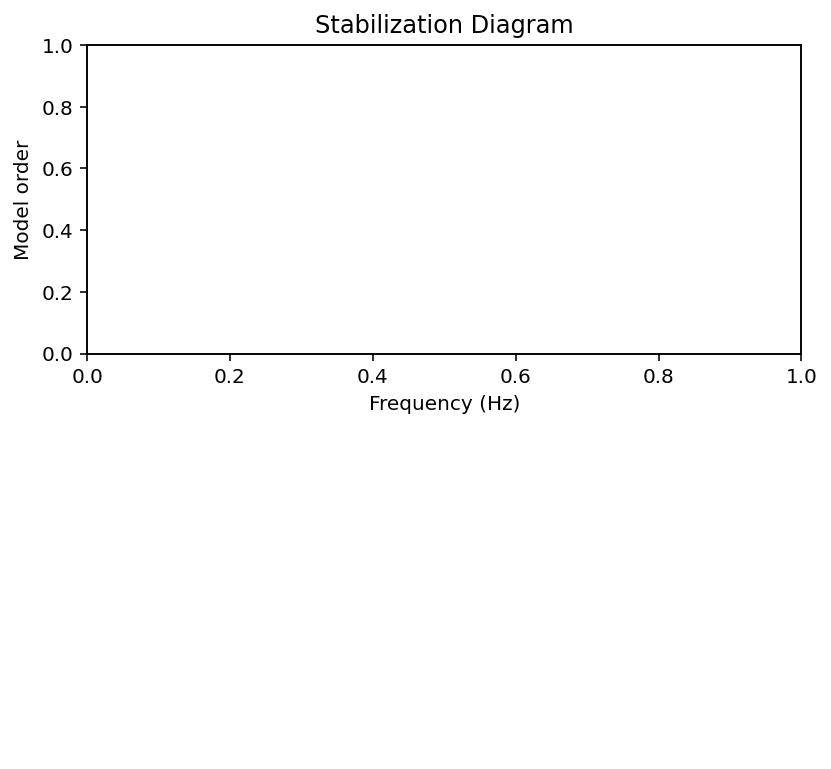

In [41]:
number_of_periods = len(loader.periods)
print("Number of perdiods to run " + str(number_of_periods))
freq_modes = []
number_in_sample = fs*60*analysis_length
stabdiag = strid.StabilizationDiagram()

In [ ]:
skipped = 0
for period in range(number_of_periods):
    #remove 10 periods and start at the 10th period
    acc = loader.load_all_acceleration_data(loader.periods[period], preprosess=True, cutoff_frequency=cutoff_frequency, filter_order=10)

    #print(type(acc))
    #If all channels are present, proceed with split up in intervals and perform Cov-SSI and clustering, if not, move to the next period
    if isinstance(acc, np.ndarray):
        acc = np.array_split(acc, acc.shape[0]/number_in_sample)
        #print(len(acc))

        for j in range(len(acc)): #add -15 here for testing

            t0 = time() #Start timer of computation process

            t0_cov = time()
            #Cov-SSI call
            ssid = strid.CovarianceDrivenStochasticSID(acc[j].transpose(), fs, ix_references)
            modes = {}
            for order in orders:
                A, C, G, R0 = ssid.perform(order, i)
                modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs)
            #modes = stabdiag.filter_modes(modes)

            #Sorting routine
            #orders = []
            lambdas = []
            phis = []

            for order in modes.keys():
                modes_in_order = modes[order]
                lambdas_in_order = []
                phis_in_order = []
                for mode in modes_in_order:
                    #orders.append(order)
                    lambdas_in_order.append(mode.eigenvalue)
                    phis_in_order.append(mode.eigenvector)
                #print("lambdas: " + str(lambdas_in_order))
                #print("phis: " + str(phis_in_order))
                lambdas.append(np.array(lambdas_in_order))
                phis.append(np.array(phis_in_order).transpose())

            #lambdas = lambdas[1:]
            #phis = phis[1:]
            #orders = np.array(orders)
            t1_cov = time()
            print("Cov-SSI executed in " + str(t1_cov - t0_cov))

            #Find stable poles routine from KOMA package here -> doesn't quite work yet
            lambd_stab, phi_stab, orders_stab, idx_stab = koma.oma.find_stable_poles(lambdas, phis, orders, s, stabcrit=stabcrit, valid_range={'freq': [0, np.inf], 'damping':[0, np.inf]}, indicator='freq', return_both_conjugates=False)

            t0_hdbscan = time()
            #Pole clustering
            pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
            prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
            args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

            xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

            #plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

            xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
            fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

            xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
            fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi
            t1_hdbscan = time()
            print("HDBSCAN executed in " + str(t1_hdbscan - t0_hdbscan))

            t0_sort = time()
            #Sort and arrange modeshapes
            # Group only a selected quantity (e.g. indices)
            lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)

            grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)

            phi_extracted = np.zeros((len(grouped_phis), len(loader.acceleration_sensors)*3))

            for a in range(len(grouped_phis)):
                for b in range(np.shape(grouped_phis[a])[0]):
                   phi_extracted[a,b] = (np.real(np.mean(grouped_phis[a][b])))
            t1_sort = time()
            print("Post processing executed in " + str(t1_sort - t0_sort))

            t0_stab = time()
            #Save stabilization plot
            stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)
            plt.savefig("plots/stab_diag/stabilization_diagram_" + str(period+1) + "_" + str(j+1) + ".jpg")
            t1_stab = time()
            print("Stabilization diagram executed in " + str(t1_stab - t0_stab))

            freq_modes.append([freq for freq in fn_mean])

            t0_wind = time()
            #Load wind statistical data for analyzed time series
            mean_wind_speed, max_wind_speed = loader.load_wind_stat_data(loader.periods[period], analysis_length, j)
            t1_wind = time()
            print("Wind statistics executed in " + str(t1_wind - t0_wind))

            t1 = time() #end timer of computation process
            print("Time serie " + str(j+1) + " of " + str(len(acc)) + " done in " + str(t1-t0) + " sec. Period " + str(period+1) + " of " + str(number_of_periods) + " done. Number of skipped periods: " + str(skipped)+".")

            #Prepare timestamp of the time series in process
            timestamp = (datetime.strptime(loader.periods[period], "%Y-%m-%d-%H-%M-%S") + timedelta(minutes=j*analysis_length)).strftime("%Y-%m-%d-%H-%M-%S")

            #Write results to h5 file
            #res_data = np.vstack([fn_mean, 100*xi_mean]).T
            with h5py.File(os.getcwd() + '/results/output_AOMA.h5', 'a') as hdf:
                G1 = hdf.create_group(timestamp)

                #Write results
                G1.create_dataset('Frequencies', data=fn_mean)
                G1.create_dataset('Damping', data=xi_mean)
                G1.create_dataset('Modeshape', data=phi_extracted)

                #Write attributes
                G1.attrs['Mean wind speed'] = mean_wind_speed
                G1.attrs['Max wind speed'] = max_wind_speed
                G1.attrs['Execution time'] = (t1-t0)
                G1.attrs['Std of acceleration data'] = np.mean(np.std(acc[j], axis=0))

    else:
        skipped += 1
        print("One or more channels are missing, period skipped.")

One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
Cov-SSI executed in 2.185961961746216
HDBSCAN executed in 0.044153690338134766
Post processing executed in 0.02358388900756836


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19458603858947754
Wind statistics executed in 0.002904176712036133
Time serie 1 of 16 done in 2.620836019515991 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6640880107879639
HDBSCAN executed in 0.044245004653930664
Post processing executed in 0.0247650146484375


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19256091117858887
Wind statistics executed in 0.003312349319458008
Time serie 2 of 16 done in 2.119661808013916 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5342469215393066
HDBSCAN executed in 0.04263901710510254
Post processing executed in 0.024908781051635742


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18589496612548828
Wind statistics executed in 0.004197835922241211
Time serie 3 of 16 done in 1.9857730865478516 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4529829025268555
HDBSCAN executed in 0.04965686798095703
Post processing executed in 0.026818037033081055


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18273186683654785
Wind statistics executed in 0.002789735794067383
Time serie 4 of 16 done in 1.9181530475616455 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.547780990600586
HDBSCAN executed in 0.049828290939331055


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02964615821838379
Stabilization diagram executed in 0.19226813316345215
Wind statistics executed in 0.0029120445251464844
Time serie 5 of 16 done in 1.9952452182769775 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.1357879638671875
HDBSCAN executed in 0.03763604164123535
Post processing executed in 0.021564006805419922


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.30539798736572266
Wind statistics executed in 0.0038259029388427734
Time serie 6 of 16 done in 1.6915538311004639 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6450848579406738
HDBSCAN executed in 0.040900230407714844
Post processing executed in 0.02448582649230957


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1813809871673584
Wind statistics executed in 0.0028541088104248047
Time serie 7 of 16 done in 2.1044397354125977 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.2208383083343506
HDBSCAN executed in 0.04667925834655762
Post processing executed in 0.02849411964416504


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1824178695678711
Wind statistics executed in 0.0029289722442626953
Time serie 8 of 16 done in 1.68609619140625 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.2172491550445557
HDBSCAN executed in 0.03771519660949707
Post processing executed in 0.022847414016723633


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18098092079162598
Wind statistics executed in 0.0031778812408447266
Time serie 9 of 16 done in 1.6493949890136719 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.1622769832611084
HDBSCAN executed in 0.04039931297302246
Post processing executed in 0.02509593963623047


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17864394187927246
Wind statistics executed in 0.0035631656646728516
Time serie 10 of 16 done in 1.608048915863037 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.3956260681152344
HDBSCAN executed in 0.042215824127197266
Post processing executed in 0.024541139602661133


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1814861297607422
Wind statistics executed in 0.002885103225708008
Time serie 11 of 16 done in 1.846019983291626 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.0977940559387207
HDBSCAN executed in 0.03914308547973633
Post processing executed in 0.023668289184570312


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17777490615844727
Wind statistics executed in 0.003203868865966797
Time serie 12 of 16 done in 1.5194568634033203 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4964029788970947
HDBSCAN executed in 0.05853724479675293
Post processing executed in 0.02440500259399414


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1859288215637207
Wind statistics executed in 0.1591329574584961
Time serie 13 of 16 done in 2.0806689262390137 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6375370025634766
HDBSCAN executed in 0.04874300956726074
Post processing executed in 0.027786970138549805


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19220495223999023
Wind statistics executed in 0.003158092498779297
Time serie 14 of 16 done in 2.092841148376465 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4193789958953857
HDBSCAN executed in 0.04065394401550293
Post processing executed in 0.024060964584350586


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17761564254760742
Wind statistics executed in 0.003181934356689453
Time serie 15 of 16 done in 1.8564753532409668 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.0746219158172607
HDBSCAN executed in 0.0377500057220459
Post processing executed in 0.02495884895324707


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18537616729736328
Wind statistics executed in 0.002808094024658203
Time serie 16 of 16 done in 1.511596918106079 sec. Period 13 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.903424024581909
HDBSCAN executed in 0.04277992248535156
Post processing executed in 0.025684833526611328


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1959521770477295
Wind statistics executed in 0.014273881912231445
Time serie 1 of 16 done in 3.3817522525787354 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.951706886291504
HDBSCAN executed in 0.04428291320800781
Post processing executed in 0.027479171752929688


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.32928991317749023
Wind statistics executed in 0.0031332969665527344
Time serie 2 of 16 done in 2.555036783218384 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0311639308929443
HDBSCAN executed in 0.05748891830444336
Post processing executed in 0.0291750431060791


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20097994804382324
Wind statistics executed in 0.0032129287719726562
Time serie 3 of 16 done in 2.525815963745117 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0731160640716553


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.045454978942871094
Post processing executed in 0.02902507781982422
Stabilization diagram executed in 0.1816120147705078
Wind statistics executed in 0.0029408931732177734
Time serie 4 of 16 done in 2.497371196746826 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.250054121017456
HDBSCAN executed in 0.04654502868652344
Post processing executed in 0.02851700782775879


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/dataloader_halogaland/plot.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax =plt.subplots(figsize=(14, 5), dpi=300)


Stabilization diagram executed in 0.18552136421203613
Wind statistics executed in 0.003267049789428711
Time serie 5 of 16 done in 1.7153990268707275 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.2247629165649414
HDBSCAN executed in 0.04248690605163574


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02664017677307129
Stabilization diagram executed in 0.18602299690246582
Wind statistics executed in 0.002753019332885742
Time serie 6 of 16 done in 1.6449658870697021 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5544500350952148
HDBSCAN executed in 0.04895591735839844
Post processing executed in 0.025324106216430664


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19524192810058594
Wind statistics executed in 0.002846240997314453
Time serie 7 of 16 done in 1.9953594207763672 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0636210441589355
HDBSCAN executed in 0.053967952728271484
Post processing executed in 0.026247262954711914


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1878190040588379
Wind statistics executed in 0.003180980682373047
Time serie 8 of 16 done in 2.5377871990203857 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4558727741241455
HDBSCAN executed in 0.04581594467163086
Post processing executed in 0.02466726303100586


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18738603591918945
Wind statistics executed in 0.003197193145751953
Time serie 9 of 16 done in 1.9110736846923828 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 3.1034369468688965


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.04677104949951172
Post processing executed in 0.027050018310546875
Stabilization diagram executed in 0.19437789916992188
Wind statistics executed in 0.0028150081634521484
Time serie 10 of 16 done in 3.53534197807312 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0292630195617676
HDBSCAN executed in 0.04118800163269043
Post processing executed in 0.025750160217285156


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19701600074768066
Wind statistics executed in 0.0029668807983398438
Time serie 11 of 16 done in 2.46277117729187 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.3062849044799805
HDBSCAN executed in 0.04065275192260742
Post processing executed in 0.02277994155883789


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18616604804992676
Wind statistics executed in 0.00298309326171875
Time serie 12 of 16 done in 2.742871046066284 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6964449882507324
HDBSCAN executed in 0.04017901420593262
Post processing executed in 0.02380514144897461


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17753386497497559
Wind statistics executed in 0.003541231155395508
Time serie 13 of 16 done in 2.133519172668457 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.720123052597046
HDBSCAN executed in 0.04535388946533203
Post processing executed in 0.026053905487060547


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1788318157196045
Wind statistics executed in 0.002835988998413086
Time serie 14 of 16 done in 2.1739790439605713 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.587838888168335
HDBSCAN executed in 0.034664154052734375
Post processing executed in 0.02216815948486328


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18390512466430664
Wind statistics executed in 0.0026650428771972656
Time serie 15 of 16 done in 2.0146329402923584 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9254319667816162
HDBSCAN executed in 0.04066777229309082
Post processing executed in 0.024972915649414062


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.338824987411499
Wind statistics executed in 0.0026869773864746094
Time serie 16 of 16 done in 2.5066978931427 sec. Period 14 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.110990047454834
HDBSCAN executed in 0.03773093223571777
Post processing executed in 0.02446269989013672


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18530988693237305
Wind statistics executed in 0.01684403419494629
Time serie 1 of 16 done in 2.567566156387329 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.586298704147339
HDBSCAN executed in 0.03586101531982422
Post processing executed in 0.022556781768798828


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18535900115966797
Wind statistics executed in 0.0031359195709228516
Time serie 2 of 16 done in 2.990043878555298 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5537137985229492
HDBSCAN executed in 0.04093575477600098
Post processing executed in 0.024999141693115234


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20427274703979492
Wind statistics executed in 0.003297090530395508
Time serie 3 of 16 done in 2.035022735595703 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7023308277130127
HDBSCAN executed in 0.037197113037109375
Post processing executed in 0.022822856903076172


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18930578231811523
Wind statistics executed in 0.003086090087890625
Time serie 4 of 16 done in 2.117335796356201 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5030200481414795
HDBSCAN executed in 0.047637939453125
Post processing executed in 0.026393890380859375


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18952202796936035
Wind statistics executed in 0.004347085952758789
Time serie 5 of 16 done in 1.97184419631958 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.013360023498535
HDBSCAN executed in 0.04321885108947754
Post processing executed in 0.02544403076171875


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1861860752105713
Wind statistics executed in 1.1225271224975586
Time serie 6 of 16 done in 3.5861499309539795 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.5587589740753174
HDBSCAN executed in 0.04634809494018555
Post processing executed in 0.028041839599609375


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20164799690246582
Wind statistics executed in 0.002863168716430664
Time serie 7 of 16 done in 3.0190958976745605 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.3568968772888184
HDBSCAN executed in 0.047074079513549805
Post processing executed in 0.025708675384521484


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18935394287109375
Wind statistics executed in 0.003133058547973633
Time serie 8 of 16 done in 2.830080032348633 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.279733896255493
HDBSCAN executed in 0.05456900596618652
Post processing executed in 0.025722980499267578


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18215274810791016
Wind statistics executed in 0.0030541419982910156
Time serie 9 of 16 done in 2.7549710273742676 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5313489437103271
HDBSCAN executed in 0.039196014404296875
Post processing executed in 0.023370981216430664


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19092202186584473
Wind statistics executed in 0.002853870391845703
Time serie 10 of 16 done in 1.9532737731933594 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.8383359909057617
HDBSCAN executed in 0.07215595245361328
Post processing executed in 0.029095888137817383


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.2147049903869629
Wind statistics executed in 0.0031669139862060547
Time serie 11 of 16 done in 3.345240831375122 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.5357141494750977
HDBSCAN executed in 0.03809976577758789
Post processing executed in 0.02407979965209961


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19853997230529785
Wind statistics executed in 0.003464221954345703
Time serie 12 of 16 done in 2.991533041000366 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9971239566802979
HDBSCAN executed in 0.043830156326293945
Post processing executed in 0.025127887725830078


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19079017639160156
Wind statistics executed in 0.0029387474060058594
Time serie 13 of 16 done in 2.465334892272949 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.6478219032287598
HDBSCAN executed in 0.035334110260009766
Post processing executed in 0.022274017333984375


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18778324127197266
Wind statistics executed in 0.003092050552368164
Time serie 14 of 16 done in 3.081965923309326 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 3.121691942214966
HDBSCAN executed in 0.04695296287536621
Post processing executed in 0.025647878646850586


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18891692161560059
Wind statistics executed in 0.006200075149536133
Time serie 15 of 16 done in 3.5910699367523193 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9391229152679443
HDBSCAN executed in 0.048979759216308594


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02824234962463379
Stabilization diagram executed in 0.1893160343170166
Wind statistics executed in 0.00333404541015625
Time serie 16 of 16 done in 2.376199722290039 sec. Period 15 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.609178066253662
HDBSCAN executed in 0.05159187316894531
Post processing executed in 0.024918079376220703


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.37438201904296875
Wind statistics executed in 0.01376795768737793
Time serie 1 of 16 done in 2.2766661643981934 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 3.042293071746826
HDBSCAN executed in 0.03609800338745117
Post processing executed in 0.024626970291137695


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.21263694763183594
Wind statistics executed in 0.0032029151916503906
Time serie 2 of 16 done in 3.499504327774048 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.4813382625579834
HDBSCAN executed in 0.04321599006652832
Post processing executed in 0.026246070861816406


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1941080093383789
Wind statistics executed in 0.003058195114135742
Time serie 3 of 16 done in 2.94244122505188 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.445930004119873
HDBSCAN executed in 0.03863096237182617
Post processing executed in 0.02452874183654785


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19868898391723633
Wind statistics executed in 0.002748727798461914
Time serie 4 of 16 done in 1.8950300216674805 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.22416090965271
HDBSCAN executed in 0.039333343505859375
Post processing executed in 0.02381420135498047


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18305206298828125
Wind statistics executed in 0.00373077392578125
Time serie 5 of 16 done in 1.668820858001709 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.1242222785949707
HDBSCAN executed in 0.03701496124267578
Post processing executed in 0.022488117218017578


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18005084991455078
Wind statistics executed in 0.003295421600341797
Time serie 6 of 16 done in 1.5526888370513916 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.1182100772857666
HDBSCAN executed in 0.04245495796203613
Post processing executed in 0.02639484405517578


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19543671607971191
Wind statistics executed in 0.002804994583129883
Time serie 7 of 16 done in 1.5641191005706787 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.102362871170044
HDBSCAN executed in 0.03976011276245117
Post processing executed in 0.02281975746154785


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1793053150177002
Wind statistics executed in 0.003130197525024414
Time serie 8 of 16 done in 2.539799928665161 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9837403297424316
HDBSCAN executed in 0.049492835998535156


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.0268552303314209
Stabilization diagram executed in 0.1894540786743164
Wind statistics executed in 0.0030100345611572266
Time serie 9 of 16 done in 2.413792133331299 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7364978790283203
HDBSCAN executed in 0.04335904121398926
Post processing executed in 0.024228811264038086


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18505382537841797
Wind statistics executed in 0.0032739639282226562
Time serie 10 of 16 done in 2.190814971923828 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.398332118988037
HDBSCAN executed in 0.04131197929382324
Post processing executed in 0.02596879005432129


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17965388298034668
Wind statistics executed in 0.0029549598693847656
Time serie 11 of 16 done in 1.8441479206085205 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.3373901844024658
HDBSCAN executed in 0.038511037826538086


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02570486068725586
Stabilization diagram executed in 0.18309497833251953
Wind statistics executed in 0.003007173538208008
Time serie 12 of 16 done in 1.7542800903320312 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5554568767547607
HDBSCAN executed in 0.04080486297607422
Post processing executed in 0.024762868881225586


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18619203567504883
Wind statistics executed in 0.0033032894134521484
Time serie 13 of 16 done in 2.0153021812438965 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9808008670806885
HDBSCAN executed in 0.041845083236694336
Post processing executed in 0.0251922607421875


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19088006019592285
Wind statistics executed in 0.002516031265258789
Time serie 14 of 16 done in 2.423529863357544 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.2003059387207031
HDBSCAN executed in 0.04517197608947754


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.028850078582763672
Stabilization diagram executed in 0.19358611106872559
Wind statistics executed in 0.0029268264770507812
Time serie 15 of 16 done in 1.6379878520965576 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5045411586761475
HDBSCAN executed in 0.03373098373413086
Post processing executed in 0.023087024688720703


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18210816383361816
Wind statistics executed in 0.003159046173095703
Time serie 16 of 16 done in 1.9311001300811768 sec. Period 16 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.5504958629608154
HDBSCAN executed in 0.03643798828125
Post processing executed in 0.02349996566772461


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1977388858795166
Wind statistics executed in 0.013724803924560547
Time serie 1 of 16 done in 2.9780187606811523 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.200654983520508
HDBSCAN executed in 0.049347877502441406
Post processing executed in 0.021754741668701172


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19483685493469238
Wind statistics executed in 0.0032167434692382812
Time serie 2 of 16 done in 2.628140926361084 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.3185160160064697
HDBSCAN executed in 0.0590059757232666
Post processing executed in 0.025416851043701172


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1885530948638916
Wind statistics executed in 0.0032219886779785156
Time serie 3 of 16 done in 2.791701078414917 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.2876811027526855
HDBSCAN executed in 0.037873268127441406
Post processing executed in 0.023076772689819336


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18332600593566895
Wind statistics executed in 0.0027327537536621094
Time serie 4 of 16 done in 1.7273249626159668 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0686838626861572
HDBSCAN executed in 0.04832625389099121
Post processing executed in 0.026200056076049805


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19870710372924805
Wind statistics executed in 0.003144979476928711
Time serie 5 of 16 done in 2.5463337898254395 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8504531383514404
HDBSCAN executed in 0.051403045654296875
Post processing executed in 0.023820877075195312


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18451929092407227
Wind statistics executed in 0.002752065658569336
Time serie 6 of 16 done in 2.2993509769439697 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9034101963043213
HDBSCAN executed in 0.03530097007751465
Post processing executed in 0.022771835327148438


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19651198387145996
Wind statistics executed in 0.0031354427337646484
Time serie 7 of 16 done in 2.317662000656128 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.043686866760254
HDBSCAN executed in 0.05924105644226074


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.024197101593017578
Stabilization diagram executed in 0.1754310131072998
Wind statistics executed in 0.003083944320678711
Time serie 8 of 16 done in 2.4684338569641113 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 4.535599231719971
HDBSCAN executed in 0.03344297409057617
Post processing executed in 0.02144598960876465


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19527506828308105
Wind statistics executed in 0.004505157470703125
Time serie 9 of 16 done in 4.94563102722168 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 3.2379298210144043
HDBSCAN executed in 0.043122291564941406
Post processing executed in 0.025264739990234375


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19760823249816895
Wind statistics executed in 0.003549814224243164
Time serie 10 of 16 done in 3.709970235824585 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.830008029937744
HDBSCAN executed in 0.038777828216552734
Post processing executed in 0.02269291877746582


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19994592666625977
Wind statistics executed in 0.003177165985107422
Time serie 11 of 16 done in 3.2741103172302246 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7331929206848145
HDBSCAN executed in 0.03460884094238281
Post processing executed in 0.021358966827392578


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1921558380126953
Wind statistics executed in 0.004176139831542969
Time serie 12 of 16 done in 2.1388490200042725 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0859689712524414
HDBSCAN executed in 0.041207075119018555


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.023645877838134766
Stabilization diagram executed in 0.20195293426513672
Wind statistics executed in 0.002789020538330078
Time serie 13 of 16 done in 2.5183773040771484 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8458428382873535
HDBSCAN executed in 0.04431796073913574
Post processing executed in 0.026874065399169922


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1853160858154297
Wind statistics executed in 0.002850055694580078
Time serie 14 of 16 done in 2.3120172023773193 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8222808837890625
HDBSCAN executed in 0.03838491439819336
Post processing executed in 0.023479223251342773


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19034290313720703
Wind statistics executed in 0.0033469200134277344
Time serie 15 of 16 done in 2.2684781551361084 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.9273290634155273
HDBSCAN executed in 0.039314985275268555
Post processing executed in 0.02487969398498535


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1890430450439453
Wind statistics executed in 0.003213167190551758
Time serie 16 of 16 done in 3.3772969245910645 sec. Period 17 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9746980667114258
HDBSCAN executed in 0.0404820442199707
Post processing executed in 0.02577996253967285


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18141889572143555
Wind statistics executed in 0.013812065124511719
Time serie 1 of 16 done in 2.439237117767334 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.31549072265625
HDBSCAN executed in 0.04119706153869629


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.026294946670532227
Stabilization diagram executed in 0.17878293991088867
Wind statistics executed in 0.0028340816497802734
Time serie 2 of 16 done in 1.728790044784546 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6454451084136963
HDBSCAN executed in 0.03427720069885254
Post processing executed in 0.02229595184326172


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18174314498901367
Wind statistics executed in 0.0027179718017578125
Time serie 3 of 16 done in 2.044132709503174 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5459668636322021
HDBSCAN executed in 0.04360604286193848
Post processing executed in 0.026123046875


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1814279556274414
Wind statistics executed in 0.002888917922973633
Time serie 4 of 16 done in 1.9744987487792969 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0914199352264404
HDBSCAN executed in 0.038297176361083984
Post processing executed in 0.02489924430847168


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18464994430541992
Wind statistics executed in 0.0029349327087402344
Time serie 5 of 16 done in 2.524839162826538 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8621840476989746
HDBSCAN executed in 0.0368499755859375
Post processing executed in 0.02411794662475586


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1834859848022461
Wind statistics executed in 0.0032739639282226562
Time serie 6 of 16 done in 2.29542875289917 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.294800281524658
HDBSCAN executed in 0.032523155212402344
Post processing executed in 0.020419836044311523


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18407583236694336
Wind statistics executed in 0.0032138824462890625
Time serie 7 of 16 done in 2.716931104660034 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1867849826812744
HDBSCAN executed in 0.04490208625793457
Post processing executed in 0.021734952926635742


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18016600608825684
Wind statistics executed in 0.0031900405883789062
Time serie 8 of 16 done in 2.616786003112793 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.162438154220581
HDBSCAN executed in 0.03513503074645996
Post processing executed in 0.022086143493652344


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18355202674865723
Wind statistics executed in 0.003094196319580078
Time serie 9 of 16 done in 2.6048829555511475 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7029080390930176
HDBSCAN executed in 0.039714813232421875
Post processing executed in 0.02526378631591797


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18546676635742188
Wind statistics executed in 0.0028340816497802734
Time serie 10 of 16 done in 2.1342029571533203 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.057309865951538
HDBSCAN executed in 0.04990196228027344
Post processing executed in 0.025052309036254883


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.43440699577331543
Wind statistics executed in 0.0032341480255126953
Time serie 11 of 16 done in 2.764112949371338 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8267168998718262
HDBSCAN executed in 0.03952312469482422
Post processing executed in 0.024901151657104492


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18966317176818848
Wind statistics executed in 0.0028519630432128906
Time serie 12 of 16 done in 2.2717928886413574 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.867567777633667
HDBSCAN executed in 0.04871988296508789


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02538323402404785
Stabilization diagram executed in 0.18322205543518066
Wind statistics executed in 0.002521991729736328
Time serie 13 of 16 done in 2.287574052810669 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 5.43594217300415
HDBSCAN executed in 0.0366208553314209
Post processing executed in 0.02285313606262207


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18210625648498535
Wind statistics executed in 0.0029642581939697266
Time serie 14 of 16 done in 5.8683083057403564 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.385453939437866
HDBSCAN executed in 0.03551197052001953
Post processing executed in 0.022939205169677734


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18590402603149414
Wind statistics executed in 0.0029692649841308594
Time serie 15 of 16 done in 2.782771348953247 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.2049310207366943
HDBSCAN executed in 0.03908133506774902
Post processing executed in 0.024183988571166992


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17951703071594238
Wind statistics executed in 0.0031707286834716797
Time serie 16 of 16 done in 2.6345250606536865 sec. Period 18 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.7930190563201904
HDBSCAN executed in 0.034098148345947266
Post processing executed in 0.022697925567626953


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19591903686523438
Wind statistics executed in 0.016852855682373047
Time serie 1 of 16 done in 3.2445759773254395 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.6052439212799072
HDBSCAN executed in 0.056121110916137695
Post processing executed in 0.027845144271850586


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20015716552734375
Wind statistics executed in 0.0028128623962402344
Time serie 2 of 16 done in 3.089648962020874 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 3.5638489723205566
HDBSCAN executed in 0.03791689872741699
Post processing executed in 0.02369093894958496


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19529080390930176
Wind statistics executed in 0.0029921531677246094
Time serie 3 of 16 done in 4.0135040283203125 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.2401440143585205
HDBSCAN executed in 0.03716301918029785
Post processing executed in 0.024094820022583008


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1826481819152832
Wind statistics executed in 0.003017902374267578
Time serie 4 of 16 done in 2.6600289344787598 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.100229024887085
HDBSCAN executed in 0.03311586380004883
Post processing executed in 0.021884918212890625


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1850266456604004
Wind statistics executed in 0.0032749176025390625
Time serie 5 of 16 done in 2.5029430389404297 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.061460018157959
HDBSCAN executed in 0.0457310676574707
Post processing executed in 0.023391008377075195


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19126033782958984
Wind statistics executed in 0.0028641223907470703
Time serie 6 of 16 done in 2.5199129581451416 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9330217838287354
HDBSCAN executed in 0.042604923248291016
Post processing executed in 0.02556586265563965


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18776822090148926
Wind statistics executed in 0.003117084503173828
Time serie 7 of 16 done in 2.3826329708099365 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.182662010192871
HDBSCAN executed in 0.04424023628234863
Post processing executed in 0.026059865951538086


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18310213088989258
Wind statistics executed in 0.0033440589904785156
Time serie 8 of 16 done in 2.6417999267578125 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5386250019073486
HDBSCAN executed in 0.04278898239135742
Post processing executed in 0.02570796012878418


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19411110877990723
Wind statistics executed in 0.0028679370880126953
Time serie 9 of 16 done in 1.9810607433319092 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.257572889328003
HDBSCAN executed in 0.037676095962524414
Post processing executed in 0.023288965225219727


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18139290809631348
Wind statistics executed in 0.002725839614868164
Time serie 10 of 16 done in 2.6999289989471436 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.814330816268921
HDBSCAN executed in 0.05380511283874512
Post processing executed in 0.026378154754638672


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17816495895385742
Wind statistics executed in 0.0029571056365966797
Time serie 11 of 16 done in 2.285648822784424 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0538549423217773
HDBSCAN executed in 0.04108119010925293
Post processing executed in 0.0248262882232666


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18222713470458984
Wind statistics executed in 0.002730846405029297
Time serie 12 of 16 done in 2.499631881713867 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8980090618133545
HDBSCAN executed in 0.04732704162597656
Post processing executed in 0.023740053176879883


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17897915840148926
Wind statistics executed in 0.002670764923095703
Time serie 13 of 16 done in 2.3502378463745117 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8127810955047607
HDBSCAN executed in 0.04111194610595703
Post processing executed in 0.025638103485107422


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17934203147888184
Wind statistics executed in 0.002833843231201172
Time serie 14 of 16 done in 2.252281665802002 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9408929347991943
HDBSCAN executed in 0.07011270523071289
Post processing executed in 0.021177053451538086


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18101716041564941
Wind statistics executed in 0.003061056137084961
Time serie 15 of 16 done in 2.401486873626709 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.3006069660186768
HDBSCAN executed in 0.0444180965423584
Post processing executed in 0.027421951293945312


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1856250762939453
Wind statistics executed in 0.002796173095703125
Time serie 16 of 16 done in 2.744481086730957 sec. Period 19 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0023491382598877
HDBSCAN executed in 0.04064011573791504
Post processing executed in 0.025269031524658203


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19106197357177734
Wind statistics executed in 0.013188838958740234
Time serie 1 of 16 done in 2.4417951107025146 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0062057971954346
HDBSCAN executed in 0.03865218162536621
Post processing executed in 0.02330493927001953
Stabilization diagram executed in 0.18095707893371582
Wind statistics executed in 0.0029730796813964844
Time serie 2 of 16 done in 2.405700922012329 sec. Period 20 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 1.9275760650634766
HDBSCAN executed in 0.049146175384521484
Post processing executed in 0.024116992950439453


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18112802505493164
Wind statistics executed in 0.0036559104919433594
Time serie 3 of 16 done in 2.385453939437866 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1961281299591064
HDBSCAN executed in 0.0437312126159668
Post processing executed in 0.026894092559814453


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19461607933044434
Wind statistics executed in 0.003069162368774414
Time serie 4 of 16 done in 2.6570188999176025 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0970749855041504
HDBSCAN executed in 0.03865408897399902
Post processing executed in 0.023735761642456055


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18395018577575684
Wind statistics executed in 0.002949953079223633
Time serie 5 of 16 done in 2.5166878700256348 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.874993085861206
HDBSCAN executed in 0.04109311103820801


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02651500701904297
Stabilization diagram executed in 0.48169398307800293
Wind statistics executed in 0.003036022186279297
Time serie 6 of 16 done in 2.5927999019622803 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.687148094177246
HDBSCAN executed in 0.04741811752319336
Post processing executed in 0.02269887924194336


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18634605407714844
Wind statistics executed in 0.009479999542236328
Time serie 7 of 16 done in 2.141710042953491 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.894759178161621
HDBSCAN executed in 0.03580307960510254


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02430891990661621
Stabilization diagram executed in 0.18028020858764648
Wind statistics executed in 0.002977132797241211
Time serie 8 of 16 done in 2.3273119926452637 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.295639991760254


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.04144930839538574
Post processing executed in 0.024898052215576172
Stabilization diagram executed in 0.18255305290222168
Wind statistics executed in 0.0028769969940185547
Time serie 9 of 16 done in 1.708449125289917 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.914200782775879
HDBSCAN executed in 0.039958953857421875
Post processing executed in 0.0232391357421875


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17785286903381348
Wind statistics executed in 0.002997159957885742
Time serie 10 of 16 done in 2.3394289016723633 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.340839147567749
HDBSCAN executed in 0.03969168663024902
Post processing executed in 0.02522897720336914


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18013596534729004
Wind statistics executed in 0.002977132797241211
Time serie 11 of 16 done in 1.7857210636138916 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.2124507427215576
HDBSCAN executed in 0.04030585289001465
Post processing executed in 0.024323701858520508


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17618203163146973
Wind statistics executed in 0.002989053726196289
Time serie 12 of 16 done in 2.6496968269348145 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9637408256530762
HDBSCAN executed in 0.03948688507080078
Post processing executed in 0.02644205093383789


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18054986000061035
Wind statistics executed in 0.0030069351196289062
Time serie 13 of 16 done in 2.408442974090576 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.699774980545044
HDBSCAN executed in 0.028156042098999023
Post processing executed in 0.01876211166381836


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19008684158325195
Wind statistics executed in 0.0028328895568847656
Time serie 14 of 16 done in 2.109997034072876 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9302082061767578
HDBSCAN executed in 0.03178715705871582
Post processing executed in 0.020946979522705078


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1810901165008545
Wind statistics executed in 0.0029430389404296875
Time serie 15 of 16 done in 2.3105549812316895 sec. Period 20 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8803987503051758
HDBSCAN executed in 0.04106497764587402
Post processing executed in 0.025168180465698242
Stabilization diagram executed in 0.18744778633117676
Wind statistics executed in 0.0029969215393066406
Time serie 16 of 16 done in 2.296226739883423 sec. Period 20 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 1.8911807537078857
HDBSCAN executed in 0.03664731979370117
Post processing executed in 0.023790836334228516


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1845388412475586
Wind statistics executed in 0.013699054718017578
Time serie 1 of 16 done in 2.3286218643188477 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9591469764709473
HDBSCAN executed in 0.046286821365356445
Post processing executed in 0.025053977966308594


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19095969200134277
Wind statistics executed in 0.003074169158935547
Time serie 2 of 16 done in 2.41363787651062 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9335601329803467
HDBSCAN executed in 0.04808807373046875
Post processing executed in 0.027299165725708008


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18641901016235352
Wind statistics executed in 0.0029802322387695312
Time serie 3 of 16 done in 2.4009451866149902 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.1805589199066162
HDBSCAN executed in 0.03348803520202637
Post processing executed in 0.022927045822143555


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18216800689697266
Wind statistics executed in 0.0031609535217285156
Time serie 4 of 16 done in 1.6017868518829346 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9227848052978516
HDBSCAN executed in 0.05214381217956543
Post processing executed in 0.02660202980041504


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1872572898864746
Wind statistics executed in 0.0028090476989746094
Time serie 5 of 16 done in 2.394835948944092 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4691698551177979


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.041220903396606445
Post processing executed in 0.02445507049560547
Stabilization diagram executed in 0.17836904525756836
Wind statistics executed in 0.0029048919677734375
Time serie 6 of 16 done in 1.8821046352386475 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0858702659606934
HDBSCAN executed in 0.04828786849975586
Post processing executed in 0.028749942779541016


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18354582786560059
Wind statistics executed in 0.002655029296875
Time serie 7 of 16 done in 2.5530760288238525 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1583452224731445
HDBSCAN executed in 0.039665937423706055
Post processing executed in 0.02405714988708496


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.183258056640625
Wind statistics executed in 0.0029730796813964844
Time serie 8 of 16 done in 2.6019392013549805 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1876559257507324
HDBSCAN executed in 0.035952091217041016
Post processing executed in 0.02349686622619629


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18711495399475098
Wind statistics executed in 0.0027608871459960938
Time serie 9 of 16 done in 2.6261651515960693 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9617199897766113
HDBSCAN executed in 0.03702998161315918
Post processing executed in 0.023277997970581055


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18438506126403809
Wind statistics executed in 0.0026960372924804688
Time serie 10 of 16 done in 2.3638110160827637 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7866508960723877
HDBSCAN executed in 0.030958175659179688
Post processing executed in 0.02099132537841797


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18164777755737305
Wind statistics executed in 0.0028638839721679688
Time serie 11 of 16 done in 2.206312894821167 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.89382004737854
HDBSCAN executed in 0.032296180725097656
Post processing executed in 0.021500825881958008


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17913222312927246
Wind statistics executed in 0.002966165542602539
Time serie 12 of 16 done in 2.3186068534851074 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8753178119659424
HDBSCAN executed in 0.03703904151916504
Post processing executed in 0.0223388671875


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1811070442199707
Wind statistics executed in 0.0028579235076904297
Time serie 13 of 16 done in 2.2935502529144287 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.492478847503662


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.04264330863952637
Post processing executed in 0.025264978408813477
Stabilization diagram executed in 0.18091106414794922
Wind statistics executed in 0.0025811195373535156
Time serie 14 of 16 done in 1.9148848056793213 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9180700778961182
HDBSCAN executed in 0.053440093994140625
Post processing executed in 0.027161121368408203


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1871168613433838
Wind statistics executed in 0.0028760433197021484
Time serie 15 of 16 done in 2.3972420692443848 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.555433988571167
HDBSCAN executed in 0.028982162475585938
Post processing executed in 0.018767833709716797


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18471312522888184
Wind statistics executed in 0.002769947052001953
Time serie 16 of 16 done in 2.9520699977874756 sec. Period 21 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8935348987579346
HDBSCAN executed in 0.03533315658569336
Post processing executed in 0.02290201187133789


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18061304092407227
Wind statistics executed in 0.013628005981445312
Time serie 1 of 16 done in 2.32511305809021 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0344178676605225


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.051271915435791016
Post processing executed in 0.03005194664001465
Stabilization diagram executed in 0.18954110145568848
Wind statistics executed in 0.002913951873779297
Time serie 2 of 16 done in 2.4857118129730225 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6649401187896729
HDBSCAN executed in 0.04463505744934082


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.0286407470703125
Stabilization diagram executed in 0.1916048526763916
Wind statistics executed in 0.003020763397216797
Time serie 3 of 16 done in 2.1008641719818115 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.059412956237793
HDBSCAN executed in 0.04137706756591797
Post processing executed in 0.02647995948791504
Stabilization diagram executed in 0.19165611267089844
Wind statistics executed in 0.0025510787963867188
Time serie 4 of 16 done in 2.477412223815918 sec. Period 22 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 2.1348421573638916
HDBSCAN executed in 0.030263185501098633
Post processing executed in 0.017714262008666992


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.5604381561279297
Wind statistics executed in 0.002889871597290039
Time serie 5 of 16 done in 2.9004008769989014 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9185690879821777
HDBSCAN executed in 0.054537057876586914
Post processing executed in 0.029448986053466797


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19495773315429688
Wind statistics executed in 0.0028519630432128906
Time serie 6 of 16 done in 2.3667819499969482 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.3075990676879883
HDBSCAN executed in 0.030481815338134766
Post processing executed in 0.02117776870727539


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18530678749084473
Wind statistics executed in 0.0028269290924072266
Time serie 7 of 16 done in 1.7101271152496338 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1001691818237305


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.06536984443664551
Post processing executed in 0.032176971435546875
Stabilization diagram executed in 0.19270920753479004
Wind statistics executed in 0.002955913543701172
Time serie 8 of 16 done in 2.5759103298187256 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7741179466247559
HDBSCAN executed in 0.04175305366516113
Post processing executed in 0.02529287338256836


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18121910095214844
Wind statistics executed in 0.0027670860290527344
Time serie 9 of 16 done in 2.2094180583953857 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.135295867919922
HDBSCAN executed in 0.04387617111206055
Post processing executed in 0.021474123001098633


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18813490867614746
Wind statistics executed in 0.002969026565551758
Time serie 10 of 16 done in 2.580274820327759 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.025376081466675
HDBSCAN executed in 0.04546499252319336
Post processing executed in 0.027990102767944336


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18747425079345703
Wind statistics executed in 0.003091096878051758
Time serie 11 of 16 done in 2.484189033508301 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.2523157596588135
HDBSCAN executed in 0.03835105895996094
Post processing executed in 0.023862123489379883


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17539000511169434
Wind statistics executed in 0.002933025360107422
Time serie 12 of 16 done in 2.680428981781006 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1151249408721924
HDBSCAN executed in 0.05705118179321289
Post processing executed in 0.028409719467163086


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18427705764770508
Wind statistics executed in 0.00279998779296875
Time serie 13 of 16 done in 2.5911529064178467 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6411819458007812
HDBSCAN executed in 0.046462059020996094
Post processing executed in 0.027585983276367188


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17944025993347168
Wind statistics executed in 0.0026619434356689453
Time serie 14 of 16 done in 2.095578908920288 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9220569133758545
HDBSCAN executed in 0.0721430778503418
Post processing executed in 0.035368919372558594


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19763493537902832
Wind statistics executed in 0.002686023712158203
Time serie 15 of 16 done in 2.4666740894317627 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.246628999710083
HDBSCAN executed in 0.04458880424499512
Post processing executed in 0.027798175811767578


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18749499320983887
Wind statistics executed in 0.003155946731567383
Time serie 16 of 16 done in 2.703057050704956 sec. Period 22 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8010969161987305
HDBSCAN executed in 0.03911900520324707
Post processing executed in 0.024292707443237305


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1902930736541748
Wind statistics executed in 0.014053106307983398
Time serie 1 of 16 done in 2.265092134475708 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9644660949707031
HDBSCAN executed in 0.056815147399902344
Post processing executed in 0.029513120651245117


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18665027618408203
Wind statistics executed in 0.002919912338256836
Time serie 2 of 16 done in 2.457749128341675 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.862441062927246
HDBSCAN executed in 0.0394289493560791
Post processing executed in 0.024235010147094727


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18317508697509766
Wind statistics executed in 0.0026519298553466797
Time serie 3 of 16 done in 2.3045830726623535 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6898820400238037
HDBSCAN executed in 0.07841992378234863
Post processing executed in 0.037728071212768555


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18640518188476562
Wind statistics executed in 0.002808094024658203
Time serie 4 of 16 done in 2.2329111099243164 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9130399227142334


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.11841106414794922
Post processing executed in 0.03640031814575195
Stabilization diagram executed in 0.20062994956970215
Wind statistics executed in 0.007391929626464844
Time serie 5 of 16 done in 2.4619126319885254 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7257070541381836
HDBSCAN executed in 0.047126054763793945
Post processing executed in 0.028256893157958984


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19373321533203125
Wind statistics executed in 0.003081798553466797
Time serie 6 of 16 done in 2.175567150115967 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 3.390197992324829
HDBSCAN executed in 0.06857514381408691
Post processing executed in 0.02507185935974121


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20456194877624512
Wind statistics executed in 0.04657387733459473
Time serie 7 of 16 done in 3.935835838317871 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.904973030090332
HDBSCAN executed in 0.026399850845336914
Post processing executed in 0.01835799217224121


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17774105072021484
Wind statistics executed in 0.0030562877655029297
Time serie 8 of 16 done in 2.2731950283050537 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.230699062347412
HDBSCAN executed in 0.026774883270263672
Post processing executed in 0.016923189163208008


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18640398979187012
Wind statistics executed in 0.003139972686767578
Time serie 9 of 16 done in 1.6220531463623047 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6618938446044922
HDBSCAN executed in 0.026449918746948242
Post processing executed in 0.01797199249267578


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1838061809539795
Wind statistics executed in 0.00337982177734375
Time serie 10 of 16 done in 2.0669219493865967 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1159849166870117
HDBSCAN executed in 0.03283500671386719
Post processing executed in 0.02237224578857422


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18342185020446777
Wind statistics executed in 0.0033941268920898438
Time serie 11 of 16 done in 2.5408079624176025 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9233417510986328
HDBSCAN executed in 0.03221416473388672
Post processing executed in 0.020581960678100586


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18226099014282227
Wind statistics executed in 0.0029709339141845703
Time serie 12 of 16 done in 2.328732967376709 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.2679038047790527
HDBSCAN executed in 0.07410717010498047
Post processing executed in 0.024396181106567383


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19818496704101562
Wind statistics executed in 0.0034699440002441406
Time serie 13 of 16 done in 2.75262188911438 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.832685947418213
HDBSCAN executed in 0.05039691925048828
Post processing executed in 0.02813887596130371


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20449590682983398
Wind statistics executed in 0.0032148361206054688
Time serie 14 of 16 done in 2.3191721439361572 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5372719764709473
HDBSCAN executed in 0.030478239059448242
Post processing executed in 0.02020716667175293


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19107699394226074
Wind statistics executed in 0.002927064895629883
Time serie 15 of 16 done in 1.9588258266448975 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.268873929977417
HDBSCAN executed in 0.050222158432006836
Post processing executed in 0.025795698165893555


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19993185997009277
Wind statistics executed in 0.0033521652221679688
Time serie 16 of 16 done in 2.750737190246582 sec. Period 23 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.2639338970184326
HDBSCAN executed in 0.03933215141296387
Post processing executed in 0.022784948348999023


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1885838508605957
Wind statistics executed in 0.014487981796264648
Time serie 1 of 16 done in 1.721999168395996 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4979987144470215
HDBSCAN executed in 0.031636953353881836
Post processing executed in 0.02107405662536621


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18367433547973633
Wind statistics executed in 0.0029702186584472656
Time serie 2 of 16 done in 1.912405014038086 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.6039690971374512
HDBSCAN executed in 0.0374758243560791
Post processing executed in 0.0241391658782959


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18513178825378418
Wind statistics executed in 0.0027620792388916016
Time serie 3 of 16 done in 2.026623010635376 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.5165281295776367
HDBSCAN executed in 0.0365300178527832
Post processing executed in 0.023327112197875977


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.17870330810546875
Wind statistics executed in 0.0033359527587890625
Time serie 4 of 16 done in 1.914525032043457 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.187973976135254
HDBSCAN executed in 0.04087996482849121
Post processing executed in 0.025072813034057617
Stabilization diagram executed in 0.18242287635803223
Wind statistics executed in 0.003220796585083008
Time serie 5 of 16 done in 2.5990028381347656 sec. Period 24 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 1.2090668678283691
HDBSCAN executed in 0.034422874450683594
Post processing executed in 0.02280902862548828


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18686795234680176
Wind statistics executed in 0.003222942352294922
Time serie 6 of 16 done in 1.628375768661499 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.773144006729126
HDBSCAN executed in 0.04105377197265625


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02641892433166504
Stabilization diagram executed in 0.1861262321472168
Wind statistics executed in 0.0029718875885009766
Time serie 7 of 16 done in 2.189884901046753 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8131887912750244
HDBSCAN executed in 0.05983710289001465
Post processing executed in 0.030311107635498047


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1900467872619629
Wind statistics executed in 0.0028448104858398438
Time serie 8 of 16 done in 2.3038489818573 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.185744047164917


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.04563713073730469
Post processing executed in 0.027727842330932617
Stabilization diagram executed in 0.1827840805053711
Wind statistics executed in 0.002707958221435547
Time serie 9 of 16 done in 1.6236119270324707 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1847898960113525
HDBSCAN executed in 0.04918313026428223
Post processing executed in 0.030051708221435547


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.6108081340789795
Wind statistics executed in 0.0029211044311523438
Time serie 10 of 16 done in 3.0442140102386475 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.9214026927948
HDBSCAN executed in 0.04387307167053223
Post processing executed in 0.02135777473449707


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.21756291389465332
Wind statistics executed in 0.0032339096069335938
Time serie 11 of 16 done in 3.3764097690582275 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.961465835571289
HDBSCAN executed in 0.05371212959289551
Post processing executed in 0.025979995727539062


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20247602462768555
Wind statistics executed in 0.00419926643371582
Time serie 12 of 16 done in 3.437351942062378 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.098551034927368


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.051786184310913086
Post processing executed in 0.029915809631347656
Stabilization diagram executed in 0.20780587196350098
Wind statistics executed in 0.003504037857055664
Time serie 13 of 16 done in 2.568065881729126 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.5996742248535156
HDBSCAN executed in 0.03915810585021973


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.029013633728027344
Stabilization diagram executed in 0.18729019165039062
Wind statistics executed in 0.003032207489013672
Time serie 14 of 16 done in 3.0027482509613037 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.589233875274658
HDBSCAN executed in 0.049041748046875
Post processing executed in 0.027841806411743164


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20659375190734863
Wind statistics executed in 0.0031690597534179688
Time serie 15 of 16 done in 3.055673122406006 sec. Period 24 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 3.5150909423828125
HDBSCAN executed in 0.038897037506103516
Post processing executed in 0.024422168731689453
Stabilization diagram executed in 0.20098304748535156
Wind statistics executed in 0.0029020309448242188
Time serie 16 of 16 done in 3.9450161457061768 sec. Period 24 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 2.4701130390167236
HDBSCAN executed in 0.0381169319152832
Post processing executed in 0.02320694923400879


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.2120511531829834
Wind statistics executed in 0.013275146484375
Time serie 1 of 16 done in 2.9416491985321045 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.78275465965271
HDBSCAN executed in 0.049278974533081055
Post processing executed in 0.028659343719482422


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20765423774719238
Wind statistics executed in 0.0029959678649902344
Time serie 2 of 16 done in 3.255143880844116 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.137578010559082
HDBSCAN executed in 0.041998863220214844


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02487778663635254
Stabilization diagram executed in 0.18988919258117676
Wind statistics executed in 0.002763032913208008
Time serie 3 of 16 done in 2.5503199100494385 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.17155122756958
HDBSCAN executed in 0.0412600040435791
Post processing executed in 0.02613997459411621


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1904587745666504
Wind statistics executed in 0.0031418800354003906
Time serie 4 of 16 done in 1.6314761638641357 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.450850248336792
HDBSCAN executed in 0.045744895935058594
Post processing executed in 0.028667926788330078
Stabilization diagram executed in 0.19069409370422363
Wind statistics executed in 0.0026853084564208984
Time serie 5 of 16 done in 2.8921401500701904 sec. Period 25 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 2.0761890411376953
HDBSCAN executed in 0.04448294639587402


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.026083946228027344
Stabilization diagram executed in 0.19012188911437988
Wind statistics executed in 0.002892017364501953
Time serie 6 of 16 done in 2.507089853286743 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1706528663635254
HDBSCAN executed in 0.046061038970947266
Post processing executed in 0.025711774826049805


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20314788818359375
Wind statistics executed in 0.002620220184326172
Time serie 7 of 16 done in 2.642874002456665 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1039340496063232
HDBSCAN executed in 0.03808879852294922
Post processing executed in 0.023415803909301758


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20238423347473145
Wind statistics executed in 0.003038167953491211
Time serie 8 of 16 done in 2.5617637634277344 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7593169212341309
HDBSCAN executed in 0.03586101531982422
Post processing executed in 0.023084163665771484


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19753074645996094
Wind statistics executed in 0.002988100051879883
Time serie 9 of 16 done in 2.2012147903442383 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4842617511749268
HDBSCAN executed in 0.04400300979614258
Post processing executed in 0.027325868606567383


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19012713432312012
Wind statistics executed in 0.002899169921875
Time serie 10 of 16 done in 1.9382410049438477 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.9475371837615967
HDBSCAN executed in 0.04352593421936035
Post processing executed in 0.026552915573120117


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.22324800491333008
Wind statistics executed in 0.020815134048461914
Time serie 11 of 16 done in 3.4334592819213867 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1255569458007812


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.04592013359069824
Post processing executed in 0.027920961380004883
Stabilization diagram executed in 0.2017049789428711
Wind statistics executed in 0.002952098846435547
Time serie 12 of 16 done in 2.5693070888519287 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7481977939605713
HDBSCAN executed in 0.04419398307800293
Post processing executed in 0.024734973907470703


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.2162609100341797
Wind statistics executed in 0.003616809844970703
Time serie 13 of 16 done in 2.2196359634399414 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9367010593414307
HDBSCAN executed in 0.034963130950927734


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.023450136184692383
Stabilization diagram executed in 0.2106168270111084
Wind statistics executed in 0.0032761096954345703
Time serie 14 of 16 done in 2.3626902103424072 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.815180778503418
HDBSCAN executed in 0.042456626892089844
Post processing executed in 0.026814937591552734
Stabilization diagram executed in 0.20811104774475098
Wind statistics executed in 0.002775907516479492
Time serie 15 of 16 done in 2.2588579654693604 sec. Period 25 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 2.8939309120178223
HDBSCAN executed in 0.043257951736450195
Post processing executed in 0.023717880249023438


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.2092878818511963
Wind statistics executed in 0.0036439895629882812
Time serie 16 of 16 done in 3.3593716621398926 sec. Period 25 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.7391459941864014
HDBSCAN executed in 0.030935049057006836
Post processing executed in 0.020527124404907227


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18977904319763184
Wind statistics executed in 0.017310142517089844
Time serie 1 of 16 done in 3.1467251777648926 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.322402000427246
HDBSCAN executed in 0.033067941665649414
Post processing executed in 0.021250009536743164


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18744301795959473
Wind statistics executed in 0.003773212432861328
Time serie 2 of 16 done in 1.7469861507415771 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7787399291992188
HDBSCAN executed in 0.053642988204956055
Post processing executed in 0.024378061294555664


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18930506706237793
Wind statistics executed in 0.0061092376708984375
Time serie 3 of 16 done in 2.2117388248443604 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.3105809688568115
HDBSCAN executed in 0.037799835205078125


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02541494369506836
Stabilization diagram executed in 0.18758082389831543
Wind statistics executed in 0.0027201175689697266
Time serie 4 of 16 done in 1.7216970920562744 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.1990740299224854
HDBSCAN executed in 0.03620505332946777
Post processing executed in 0.023920297622680664
Stabilization diagram executed in 0.2044517993927002
Wind statistics executed in 0.002809762954711914
Time serie 5 of 16 done in 1.6517078876495361 sec. Period 26 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 1.7692852020263672
HDBSCAN executed in 0.04715394973754883
Post processing executed in 0.02569293975830078


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18683815002441406
Wind statistics executed in 0.0031571388244628906
Time serie 6 of 16 done in 2.2358059883117676 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.2386467456817627
HDBSCAN executed in 0.03496122360229492
Post processing executed in 0.02196216583251953


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1862471103668213
Wind statistics executed in 0.0029077529907226562
Time serie 7 of 16 done in 1.6714277267456055 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.2102949619293213
HDBSCAN executed in 0.040979862213134766
Post processing executed in 0.024033784866333008


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18924999237060547
Wind statistics executed in 0.003377199172973633
Time serie 8 of 16 done in 2.630876302719116 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.675935983657837
HDBSCAN executed in 0.0410161018371582
Post processing executed in 0.024740219116210938


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19069480895996094
Wind statistics executed in 0.003103017807006836
Time serie 9 of 16 done in 2.1148951053619385 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.0964341163635254
HDBSCAN executed in 0.04209303855895996
Post processing executed in 0.02593994140625


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19915509223937988
Wind statistics executed in 0.003019094467163086
Time serie 10 of 16 done in 2.5344908237457275 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.993056058883667
HDBSCAN executed in 0.037261962890625
Post processing executed in 0.02533721923828125


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18757987022399902
Wind statistics executed in 0.0031328201293945312
Time serie 11 of 16 done in 2.4375321865081787 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.313828706741333
HDBSCAN executed in 0.04607415199279785
Post processing executed in 0.027571916580200195


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18361902236938477
Wind statistics executed in 0.002618074417114258
Time serie 12 of 16 done in 1.786026954650879 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.530752182006836
HDBSCAN executed in 0.0485689640045166
Post processing executed in 0.028645753860473633


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18465113639831543
Wind statistics executed in 0.0028412342071533203
Time serie 13 of 16 done in 2.0047731399536133 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9552772045135498
HDBSCAN executed in 0.04766273498535156
Post processing executed in 0.02792072296142578


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19434499740600586
Wind statistics executed in 0.002557992935180664
Time serie 14 of 16 done in 2.4311270713806152 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.246711015701294
HDBSCAN executed in 0.04193615913391113
Post processing executed in 0.025920867919921875


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.18688368797302246
Wind statistics executed in 0.003331899642944336
Time serie 15 of 16 done in 1.7049989700317383 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7815699577331543
HDBSCAN executed in 0.0487058162689209
Post processing executed in 0.029476165771484375


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19024991989135742
Wind statistics executed in 0.0033359527587890625
Time serie 16 of 16 done in 2.2583980560302734 sec. Period 26 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4067370891571045
HDBSCAN executed in 0.043402910232543945
Post processing executed in 0.0280001163482666


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1969149112701416
Wind statistics executed in 0.013289928436279297
Time serie 1 of 16 done in 1.8838059902191162 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4263381958007812
HDBSCAN executed in 0.045603036880493164
Post processing executed in 0.028023958206176758


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1923840045928955
Wind statistics executed in 0.0034601688385009766
Time serie 2 of 16 done in 1.895859956741333 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.2220821380615234
HDBSCAN executed in 0.04364895820617676
Post processing executed in 0.027358293533325195


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19244813919067383
Wind statistics executed in 0.0035161972045898438
Time serie 3 of 16 done in 1.6670091152191162 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4917378425598145


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


HDBSCAN executed in 0.04891395568847656
Post processing executed in 0.030601978302001953
Stabilization diagram executed in 0.1954810619354248
Wind statistics executed in 0.003099679946899414
Time serie 4 of 16 done in 1.9435200691223145 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.4065430164337158
HDBSCAN executed in 0.04632997512817383
Post processing executed in 0.02826690673828125


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.6907589435577393
Wind statistics executed in 0.0036890506744384766
Time serie 5 of 16 done in 2.364072322845459 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.9454801082611084
HDBSCAN executed in 0.04854583740234375
Post processing executed in 0.029492855072021484


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.2056570053100586
Wind statistics executed in 0.008203983306884766
Time serie 6 of 16 done in 2.4441750049591064 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.888350009918213
HDBSCAN executed in 0.05050373077392578
Post processing executed in 0.030137062072753906


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1945478916168213
Wind statistics executed in 0.0024042129516601562
Time serie 7 of 16 done in 2.3745369911193848 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.146211862564087
HDBSCAN executed in 0.0455930233001709
Post processing executed in 0.026390790939331055


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.21447205543518066
Wind statistics executed in 0.0035817623138427734
Time serie 8 of 16 done in 2.6119608879089355 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 3.5043792724609375
HDBSCAN executed in 0.049295663833618164
Post processing executed in 0.02585124969482422


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.20295310020446777
Wind statistics executed in 0.0033757686614990234
Time serie 9 of 16 done in 3.970158100128174 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.663248300552368
HDBSCAN executed in 0.039582252502441406


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02618885040283203
Stabilization diagram executed in 0.2101738452911377
Wind statistics executed in 0.003425121307373047
Time serie 10 of 16 done in 3.101425886154175 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.7449951171875
HDBSCAN executed in 0.04987812042236328
Post processing executed in 0.02781391143798828


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.2071080207824707
Wind statistics executed in 0.003706693649291992
Time serie 11 of 16 done in 2.2152791023254395 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.2156100273132324
HDBSCAN executed in 0.04911994934082031
Post processing executed in 0.029113054275512695


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.2033228874206543
Wind statistics executed in 0.004824161529541016
Time serie 12 of 16 done in 2.6992619037628174 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.8743951320648193
HDBSCAN executed in 0.07407522201538086
Post processing executed in 0.031172990798950195


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19132328033447266
Wind statistics executed in 0.0028519630432128906
Time serie 13 of 16 done in 2.386831283569336 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.1274640560150146
HDBSCAN executed in 0.05774092674255371
Post processing executed in 0.02993488311767578


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.19345402717590332
Wind statistics executed in 0.003192901611328125
Time serie 14 of 16 done in 2.6174991130828857 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 2.816481828689575
HDBSCAN executed in 0.044450998306274414


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Post processing executed in 0.02813720703125
Stabilization diagram executed in 0.20289111137390137
Wind statistics executed in 0.0027420520782470703
Time serie 15 of 16 done in 3.261620044708252 sec. Period 27 of 88 done. Number of skipped periods: 12.
Cov-SSI executed in 1.478210210800171
HDBSCAN executed in 0.04657888412475586
Post processing executed in 0.0276949405670166
Stabilization diagram executed in 0.18729233741760254
Wind statistics executed in 0.0025787353515625
Time serie 16 of 16 done in 1.9121720790863037 sec. Period 27 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Cov-SSI executed in 2.018784999847412
HDBSCAN executed in 0.05566263198852539
Post processing executed in 0.027315855026245117


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_35796/1427197658.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


Stabilization diagram executed in 0.1900191307067871
Wind statistics executed in 0.013113260269165039
Time serie 1 of 16 done in 2.4978630542755127 sec. Period 28 of 88 done. Number of skipped periods: 12.
